# Model Evaluation & Optimization

## Objective
This notebook focuses on improving model generalization by addressing target
leakage, performing feature refinement, hyperparameter tuning, and evaluating
models using reliable metrics and learning curves.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = "../data/processed/books_features.csv"
df = pd.read_csv(data_path)

df.head()

,Unnamed: 0,bookId,title,author,series,description,genres,awards,characters,places,...,num_reviews,avg_rating,rated_1,rated_2,rated_3,rated_4,rated_5,popularity_score,rating_category,liked
0,0,1,Harry Potter and the Half-Blood Prince,J.K. Rowling,Harry Potter #6,The war against Voldemort is not going well; e...,"Art,Biography,Business,Children's,Christian,Cl...",Locus Award Nominee for Best Young Adult Novel...,"Draco Malfoy,Ron Weasley,Petunia Dursley,Verno...","Hogwarts School of Witchcraft and Wizardry,Eng...",...,41470.0,4.57,13147.0,29020.0,174312.0,608825.0,1728605.0,67.421832,High,1
1,1,2,Harry Potter and the Order of the Phoenix,"J.K. Rowling,Mary GrandPré",Harry Potter #5,There is a door at the end of a silent corrido...,"Art,Biography,Business,Children's,Christian,Cl...",Bram Stoker Award for Works for Young Readers ...,"Sirius Black,Draco Malfoy,Ron Weasley,Petunia ...","Hogwarts School of Witchcraft and Wizardry,Lon...",...,44793.0,4.50,16236.0,41738.0,231438.0,665628.0,1676387.0,66.523668,High,1
2,2,3,Harry Potter and the Sorcerer's Stone,"J.K. Rowling,Mary GrandPré",Harry Potter #1,Harry Potter's life is miserable. His parents ...,"Art,Biography,Business,Children's,Christian,Cl...",Mythopoeic Fantasy Award for Children's Litera...,"Draco Malfoy,Ron Weasley,Petunia Dursley,Verno...","London, England,Hogwarts School of Witchcraft ...",...,117823.0,4.48,126344.0,147184.0,627803.0,1694206.0,4839246.0,70.881127,High,1
3,3,4,Harry Potter and the Chamber of Secrets,J.K. Rowling,Harry Potter #2,The Dursleys were so mean and hideous that sum...,"Art,Biography,Business,Children's,Christian,Cl...",Mythopoeic Fantasy Award for Children's Litera...,"Draco Malfoy,Ron Weasley,Petunia Dursley,Verno...","Hogwarts School of Witchcraft and Wizardry,Hog...",...,55839.0,4.43,15623.0,55060.0,315917.0,787181.0,1704415.0,65.885949,High,1
4,4,5,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling,Mary GrandPré",Harry Potter #3,"For twelve long years, the dread fortress of A...","Art,Biography,Business,Children's,Christian,Cl...",Bram Stoker Award for Best Work for Young Read...,"Sirius Black,Draco Malfoy,Ron Weasley,Petunia ...","Hogwarts School of Witchcraft and Wizardry,Lon...",...,58483.0,4.57,14124.0,29105.0,214151.0,701765.0,2013374.0,68.115487,High,1


In [3]:
features = [
    'num_ratings',
    'num_reviews',
    'num_pages',
    'popularity_score'
]

X = df[features]
y = df['liked']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
log_params = {
    'C': [0.01, 0.1, 1, 10]
}

log_grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    log_params,
    cv=5,
    scoring='roc_auc'
)

log_grid.fit(X_train_scaled, y_train)

best_log_model = log_grid.best_estimator_

In [8]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

best_rf_model = rf_grid.best_estimator_

In [9]:
models = {
    "Logistic Regression (Optimized)": best_log_model,
    "Random Forest (Optimized)": best_rf_model
}

results = []

for name, model in models.items():
    if "Logistic" in name:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append([name, acc, auc])

pd.DataFrame(results, columns=["Model", "Accuracy", "ROC-AUC"])

,Model,Accuracy,ROC-AUC
0,Logistic Regression (Optimized),0.622820,0.601198
1,Random Forest (Optimized),0.974589,0.997820


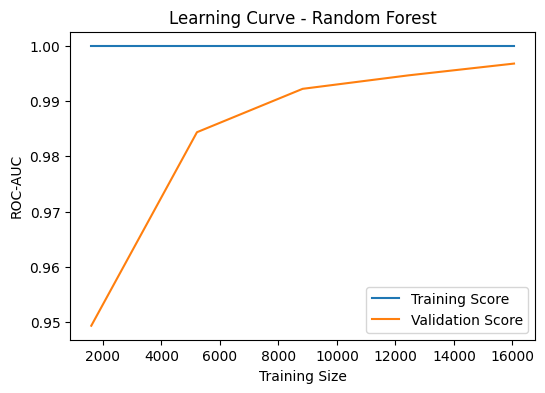

In [10]:
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model,
    X,
    y,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel("Training Size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.show()

In [11]:
import joblib

joblib.dump(best_rf_model, "../models/final_random_forest.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']